viernes 03 de mayo de 2019  
  
_Benjamín Hernández Cortés_ - _Juan Pablo Rojas Rojas_  
_Departamento de Ingeniería Informática (DIINF)_  
_Universidad de Santiago de Chile (USACH)_


## Laboratorio 2 - Fundamentos de Aprendizaje Profundo con Redes Neuronales
___

El presente código está orientado hacia la implementación de un perceptrón multicapa o red neuronal de múltiples capas (Multi-Layer Neural Network). En primera oportunidad, se utilizará el perceptrón para clasificar y emular compuertas lógicas AND, OR y XOR, tanto de 2 como de 4 entradas. Luego, se realizará una clasificación trabajando con el conjunto de datos [wine](https://archive.ics.uci.edu/ml/datasets/wine) provenientes de la [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php) que contiene 13 atributos en total y que intentan describir clases de vinos provenientes de 3 cultivos distintos.


#### Importación de bibliotecas
---

Las bibliotecas a emplear son:
- **Numpy:** Herramienta de computación científica, que nos permitirá trabajar a través de vectores
- **Pandas:** Para la manipulación y lectura de datos
- **Matplotlib:** Para la visualización gráfica de diversos datos de interés
- **Itertools:** Como herramienta para iteración de objetos
- **Scikit-learn:** Para la obtención del dataset _wine_ y el uso de herramientas de evaluación de desempeño para los perceptrones multicapa.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as its
import sklearn as skl

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine
from sklearn.metrics import precision_score, confusion_matrix
from sklearn import preprocessing

#### Definición de funciones globales
---

Para el presente laboratorio se emplearan las siguientes funciones de forma global, las cual estan enfocadas al cálculo de ciertos valores a partir de las entradas recibidas:

| <p style='text-align: left;'>**Función**</p>  | <p style='text-align: left;'>**Descripción**</p> |
| ------------ | ------------ |
| `preprocessing_data(dataset)` |  <p style='text-align: justify;'>Se realiza el procesamiento del data set, en primer lugar se aplica el procedimiento de estandarizacion o eliminación media y escala de varianza con el objetivo de tener una varianza total acorde a los datos objetivos. Por ultimo se aplica normalización de datos</p>|
| `sklearn_to_df(sklearn_dataset)` |  <p style='text-align: justify;'>Se realiza la transformación de datos desde un dataset obtenido de la biblioteca *scikit-learn*, a un dataframe de la biblioteca *pandas*</p>|

In [2]:
def preprocessing_data(dataset):
    data_col_names = dataset.columns.values
    for name in data_col_names[:-1]:
        #dataset[name] = preprocessing.scale(dataset[name])
        dataset[name] = 10 * ((dataset[name] - dataset[name].min())/(dataset[name].max()-dataset[name].min())) 
    return dataset

def sklearn_to_df(sklearn_dataset):
    df = pd.DataFrame(sklearn_dataset.data, columns=sklearn_dataset.feature_names)
    df['target'] = pd.Series(sklearn_dataset.target)
    return df

#### 1. Implementar dos funciones de activación no lineal y una lineal.

| <p style='text-align: left;'>**Función**</p>  | <p style='text-align: left;'>**Descripción**</p> |
| ------------ | ------------ |
| `sigmoid(x)` |  <p style='text-align: justify;'>Se calcula el valor para la función sigmoide (o logsig) aplicada a un conjunto de vectores $x$</p>|
| `sigmoid_derivative(x)` |  <p style='text-align: justify;'>Se calcula el valor de la derivada para la función sigmoide (o logsig) aplicada a un conjunto de vectores $x$</p>|
| `relu(x)` |  <p style='text-align: justify;'>Se calcula el valor para la función ReLU aplicada a un conjunto de vectores $x$</p>|
| `relu_derivative(x)` |  <p style='text-align: justify;'>Se calcula el valor de la derivada para la función ReLU aplicada a un conjunto de vectores $x$</p>|

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return 1 * (x > 0)

activation_functions = {
    'sigmoid': sigmoid,
    'relu': relu
}

activation_functions_derivatives = {
    'sigmoid': sigmoid_derivative,
    'relu': relu_derivative
}

#### Definición de la clase TruthTableGenerator
---

La clase TruthTableGenerator permite generar tablas de verdad para 3 tipos de compuertas lógicas: AND, OR y XOR.

En cuanto a las funciones definidas, se tiene:

| <p style='text-align: left;'>**Función**</p>  | <p style='text-align: left;'>**Descripción**</p>  |
| ------------ | ------------ |
| `generate_table(n_inputs, logic_gate)`  |  <p style='text-align: justify;'>Genera una tabla de verdad de n-variables (*n_inputs*), basada en una compuerta lógica determinada (*logic_gate*)</p>|

In [4]:
class TruthTableGenerator():
    
    def generate_table(n_inputs, logic_gate):
        table = its.product([0,1], repeat = n_inputs)
        table = pd.DataFrame(table)
        results = []
        
        for i in range(n_inputs ** 2):
            row = table.loc[[i]].values[0]
            if logic_gate == 'AND': results.append( int(all(row)) )
            elif logic_gate == 'OR': results.append( int(any(row)) )
            elif logic_gate == 'XOR':
                tmp_result = row[0] ^ row[1]
                for j in range(2, n_inputs):
                    tmp_result = tmp_result ^ row[j]
                results.append( tmp_result )
            else: return None
        
        table['result'] = results
        return table

#### Definición de la clase MLP
---
La clase MLP (Multilayer Perceptron) permite representar a un perceptrón multicapa configurable en el número de capas, número de neuronas por capa y las funciones de activación para cada capa:

| <p style='text-align: left;'>**Parámetro**</p> | <p style='text-align: left;'>**Descripción**</p> |
| ------------ | ------------ |
| `network_config` |  <p style='text-align: justify;'>Lista de enteros. Define la cantidad de neuronas por cada capa; capas que debe incluir la de entrada, las ocultas y la de salida.</p>|
| `functions` | <p style='text-align: justify;'>Lista de strings. Define las funciones de activación que empleará cada capa de la red, las cuales pueden ser tangente hiperbólica (_tanh_), sigmoide (_sigmoid_) o ReLU (_relu_).</p> |

En cuanto a las funciones definidas, se tiene:

| <p style='text-align: left;'>**Función**</p>  | <p style='text-align: left;'>**Descripción**</p> |
| ------------ | ------------ |
| `feed_forward(x)` |  <p style='text-align: justify;'>Realiza una predicción para un conjunto de datos (*x*), empleando los valores actuales de los pesos (*weights*) asociados a la capa.</p>|
| `back_propagation(y, target, learning_rate)` |  <p style='text-align: justify;'>Realiza el ajuste de los pesos de la red, según un tasa de aprendizaje (*learning_rate*) y considerando un vector de salidas esperadas (*target*).</p>|
| `training(data, targets, learning_rate, epochs)` |  <p style='text-align: justify;'>Entrena la red neuronal, mediante un conjunto de datos inicial (*data*) a comparar con un conjunto de salidas esperadas (*targets*), empleando una tasa de aprendizaje (*learning_rate*) y una cantidad de iteraciones o épocas (*epochs*) definida por el usuario.</p>|
| `predict_single_input(x)` |  <p style='text-align: justify;'>Realiza una predicción para un único dato (*x*).</p>|
| `predict(x)` |  <p style='text-align: justify;'>Realiza una predicción para un conjunto de datos (*x*).</p>|


In [5]:
class MLP:
    def __init__(self, network_config, functions):
        self.layers = len(network_config)
        self.steps_per_epoch = 1
        self.network_config = network_config
        self.activity = []
        self.activity_derivative = []
        self.weights = []

        for layer in range(self.layers - 1):
            self.activity.append(activation_functions[functions[layer]])
            self.activity_derivative.append(activation_functions_derivatives[functions[layer]])
            w = np.random.rand(network_config[layer] + 1, network_config[layer + 1]) - 1
            w *= np.sqrt(1 / network_config[layer] + network_config[layer + 1])
            self.weights.append(w)
    
    def feed_forward(self, x):
        y = x

        for i in range(len(self.weights) - 1):
            activation = np.dot(y[i], self.weights[i])
            activity = self.activity[i](activation)
            activity = np.concatenate((np.ones(1), np.array(activity)))
            y.append(activity)

        activation = np.dot(y[-1], self.weights[-1])
        activity = self.activity[-1](activation)
        y.append(activity)
        return y
    
    def back_propagation(self, y, target, learning_rate):
        error = target - y[-1]
        delta_vector = [error * self.activity_derivative[-1](y[-1])]
        for i in range(self.layers-2, 0, -1):
            error = np.dot(delta_vector[-1], self.weights[i][1:].T)
            error = error * self.activity_derivative[i](y[i][1:])
            delta_vector.append(error)

        delta_vector.reverse()
        for i in range(len(self.weights)):
            layer = y[i].reshape(1, self.network_config[i] + 1)
            delta = delta_vector[i].reshape(1, self.network_config[i + 1])
            self.weights[i] += learning_rate * np.dot(layer.T, delta)
    
    def training(self, data, targets, learning_rate=0.1, epochs=100):
        ones = np.ones((1, data.shape[0]))
        Z = np.concatenate((ones.T, data), axis=1)
        errors = []
        
        for k in range(epochs):        
            sample = np.random.randint(data.shape[0])
            x = [Z[sample]]
            y = self.feed_forward(x)
            target = targets[sample]
            errors.append(np.absolute(y[-1] - target))
            self.back_propagation(y, target, learning_rate)
        print(">> Entrenamiento finalizado :) <<")
        return errors
    
    def predict_single_input(self, x):
        val = np.concatenate((np.ones(1).T, np.array(x)))
        for i in range(0, len(self.weights)):
            val = self.activity[i](np.dot(val, self.weights[i]))
            val = np.concatenate((np.ones(1).T, np.array(val)))
        return val[1]
    
    def predict(self, X):
        Y = np.array([]).reshape(0, self.network_config[-1])
        for x in X:
            y = np.array([[self.predict_single_input(x)]])
            Y = np.vstack((Y,y))
        return Y


#### 2. Implementar   una   red   MLP   con   solo   una   capa   oculta   de   forma   genérica   para   las  diferentes funciones de activación. 

In [6]:
#Entradas: 4
#Neuronas: 2 capa escondida,1 capa salida
#Activación: Sigmoid
perceptron_sigmoid_4 = MLP(network_config = [4,2,1],
                           functions = ['sigmoid','sigmoid'])

#Entradas: 4
#Neuronas: 2 capa escondida,1 capa salida
#Activación: Relu
perceptron_relu_4 = MLP(network_config = [4,2,1],
                        functions = ['relu','relu'])

#____________________________________________________________________#
#Entradas: 2
#Neuronas: 2 capa escondida,1 capa salida
#Activación: Relu
perceptron_sigmoid_2 = MLP(network_config = [2,2,1],
                           functions = ['sigmoid','sigmoid'])

#Entradas: 2
#Neuronas: 2 capa escondida,1 capa salida
#Activación: Relu
perceptron_relu_2 = MLP(network_config = [2,2,1],
                        functions = ['relu','relu'])

#### 3. Probar   la   red   neuronal   con   las   compuertas   AND,   OR   y   XOR   para   entradas   de   tamaño  2 y 4 (+ Bias). 

In [7]:
#Tamaño 2
XOR_2 = np.array(TruthTableGenerator.generate_table(n_inputs=2, logic_gate='XOR'))
AND_2 = np.array(TruthTableGenerator.generate_table(n_inputs=2, logic_gate='AND'))
OR_2 = np.array(TruthTableGenerator.generate_table(n_inputs=2, logic_gate='OR'))

#Tamaño 4
XOR_4 = np.array(TruthTableGenerator.generate_table(n_inputs=4, logic_gate='XOR'))
AND_4 = np.array(TruthTableGenerator.generate_table(n_inputs=4, logic_gate='AND'))
OR_4 = np.array(TruthTableGenerator.generate_table(n_inputs=4, logic_gate='OR'))


#____________________________2 Entradas____________________________________________#
# >> XOR <<
error_xs2 = perceptron_sigmoid_2.training(data = XOR_2[:, :-1], targets = XOR_2[:, -1], epochs = 10000)
error_xr2 = perceptron_relu_2.training(data = XOR_2[:, :-1], targets = XOR_2[:, -1], epochs = 10000)

# >> AND <<
error_as2 = perceptron_sigmoid_2.training(data = AND_2[:, :-1], targets = AND_2[:,-1], epochs = 10000)
error_ar2 = perceptron_relu_2.training(data = AND_2[:, :-1], targets = AND_2[:, -1], epochs = 10000)


# >> OR <<
error_os2 = perceptron_sigmoid_2.training(data = OR_2[:, :-1], targets = OR_2[:, -1], epochs = 10000)
error_or2 = perceptron_relu_2.training(data = OR_2[:, :-1], targets = OR_2[:, -1], epochs = 10000)



#____________________________4 Entradas____________________________________________#
#XOR
error_xs4 = perceptron_sigmoid_4.training(XOR_4[:,:-1],XOR_4[:,-1],epochs = 10000)
error_xr4 = perceptron_relu_4.training(XOR_4[:,:-1],XOR_4[:,-1],epochs = 10000)

#AND
error_as4 = perceptron_sigmoid_4.training(AND_4[:,:-1],AND_4[:,-1],epochs = 10000)
error_ar4 = perceptron_relu_4.training(AND_4[:,:-1],AND_4[:,-1],epochs = 10000)

#OR
error_os4 = perceptron_sigmoid_4.training(OR_4[:,:-1],OR_4[:,-1],epochs = 10000)
error_or4 = perceptron_relu_4.training(OR_4[:,:-1],OR_4[:,-1],epochs = 10000)


>> Entrenamiento finalizado :) <<
>> Entrenamiento finalizado :) <<
>> Entrenamiento finalizado :) <<
>> Entrenamiento finalizado :) <<
>> Entrenamiento finalizado :) <<
>> Entrenamiento finalizado :) <<
>> Entrenamiento finalizado :) <<
>> Entrenamiento finalizado :) <<
>> Entrenamiento finalizado :) <<
>> Entrenamiento finalizado :) <<
>> Entrenamiento finalizado :) <<
>> Entrenamiento finalizado :) <<


#### 4. Mostrar   el   resultado   del   entrenamiento   mediante   un   gráfico   ​ Iteración   vs   Error   para  cada compuerta lógica.

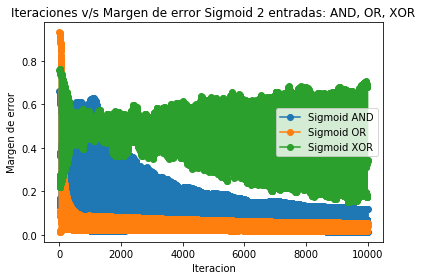

In [8]:
plt.plot(range(1,len(error_as2) + 1), error_as2, marker= "o", label = "Sigmoid AND")
plt.plot(range(1,len(error_os2) + 1), error_os2, marker= "o", label = "Sigmoid OR")
plt.plot(range(1,len(error_xs2) + 1), error_xs2, marker= "o", label = "Sigmoid XOR")
plt.title("Iteraciones v/s Margen de error Sigmoid 2 entradas: AND, OR, XOR")
plt.xlabel("Iteracion")
plt.ylabel("Margen de error")
plt.legend(loc = "center right")
plt.tight_layout()
plt.show()


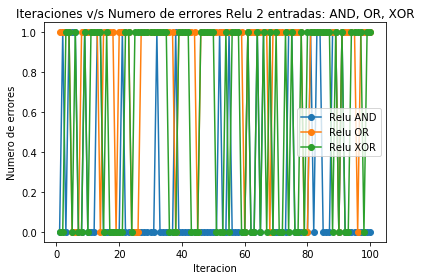

In [9]:
plt.plot(range(1,100 + 1), error_ar2[:100], marker= "o", label = "Relu AND")
plt.plot(range(1,100 + 1), error_or2[:100], marker= "o", label = "Relu OR")
plt.plot(range(1,100 + 1), error_xr2[:100], marker= "o", label = "Relu XOR")
plt.title("Iteraciones v/s Numero de errores Relu 2 entradas: AND, OR, XOR")
plt.xlabel("Iteracion")
plt.ylabel("Numero de errores")
plt.legend(loc = "center right")
plt.tight_layout()
plt.show()

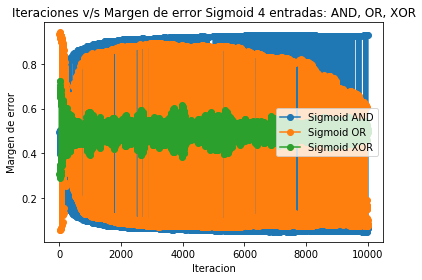

In [10]:
plt.plot(range(1,len(error_as4) + 1), error_as4, marker= "o", label = "Sigmoid AND")
plt.plot(range(1,len(error_os4) + 1), error_os4, marker= "o", label = "Sigmoid OR")
plt.plot(range(1,len(error_xs4) + 1), error_xs4, marker= "o", label = "Sigmoid XOR")
plt.title("Iteraciones v/s Margen de error Sigmoid 4 entradas: AND, OR, XOR")
plt.xlabel("Iteracion")
plt.ylabel("Margen de error")
plt.legend(loc = "center right")
plt.tight_layout()
plt.show()

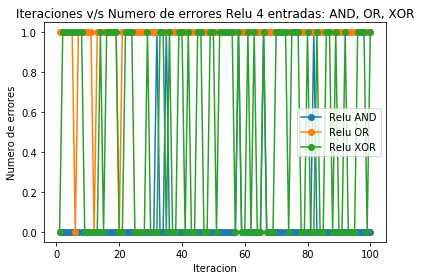

In [11]:
plt.plot(range(1,100 + 1), error_ar4[:100], marker= "o", label = "Relu AND")
plt.plot(range(1,100 + 1), error_or4[:100], marker= "o", label = "Relu OR")
plt.plot(range(1,100 + 1), error_xr4[:100], marker= "o", label = "Relu XOR")
plt.title("Iteraciones v/s Numero de errores Relu 4 entradas: AND, OR, XOR")
plt.xlabel("Iteracion")
plt.ylabel("Numero de errores")
plt.legend(loc = "center right")
plt.tight_layout()
plt.show()

#### 5. Analizar los resultados obtenidos y compararlos con el perceptrón simple.

<p style='text-align: justify;'>
El perceptrón simple fue muy efectivo para los datos de tablas que son linealmente separables, es decir, para entradas AND y OR, a diferencia de XOR en el que estuvo oscilando entre errores sin un entrenamiento correcto, porque como bien se dijo, solo funciona con clases linealmente separables.
Ahora bien en esta oportunidad se presentan 4 gráficos con resultados obtenidos dadas 10.000 iteraciones de entrenamiento por cada tabla de verdad:</p>

- <p style='text-align: justify;'>En el uso de funciones de activación Sigmoid para 4 y 2 entradas se aprecia un comportamiento similar, para ambos casos el entrenamiento de compuerta tipo XOR, se mantuvo en oscilacion en un margen de error, no siendo posible llevar este a 0. Caso contrario para compuertas tipo AND y OR, el error a medida que la iteración crece converge a 0. Un caso similar al perceptron simple.</p>


- <p style='text-align: justify;'>En el segundo caso, para funciones de activación tipo Relu de 2 entradas, se presentan las 100 primeras iteraciones para apreciar el comportamiento que se repite a lo largo de las 10.000 iteraciones, es posible apreciar una oscilacion en el margen de error, por lo que no converge en su totalidad. En el caso de ReLU con 4 entradas, la convergencia se aplica para la compuerta AND.</p>

<p style='text-align: justify;'>
Cabe destacar que la imposibilidad de convergencia de casos anteriores para un perceptron multicapa, que deberia ser posible ser aplicado en clases que no son linealmente separables, se debe a que en muchos de los casos de entrenamiento al minimizar la funcion del error se cae en muchos minimos locales, por lo que para realizar su correcto funcionamiento es necesario aplicar procedimientos de mejoras, ya que en este caso el perceptron simple es mucho más efectivo, exceptuando por XOR.</p>

#### 6. Escoger un dataset de la biblioteca sklearn (wine o breast cancer) y describirlo.

<p style='text-align: justify;'>
Para esta oportunidad, como grupo se decidió analizar el dataset _wine_, el cual contiene los resultados de analisis químicos hechos a distintos cultivos de vino, cultivados en áreas específicas de Italia. Tres tipos de vinos son representados en 178 muestras, con los resultados de 13 análisis quimicos registrados para cada muestra:

* __Alcohol:__ Nivel de alcohol
* __Malic:__ Nivel de ácido málico
* __Ash:__ Ceniza
* __Alcalinity:__ Alcalinidad de la ceniza
* __Magnesium:__ Nivel de magnesio
* __Phenols:__ Total de fenoles
* __Flavanoids:__ Fenoles que son flavonoides
* __Nonflavanoids:__ Fenoles que no son flavonoides
* __Proanthocyanins:__ Nivel de proantocianidinas
* __Color:__ Intensidad del color
* __Hue:__ Matiz
* __Dilution:__ D280/OD315 de vinos diluídos.
* __Proline:__ Nivel de prolina
* __Target:__ El tipo de vino entre una de tres clases, tipo 1 (59 obs), tipo 2(71 obs), y tipo 3 (48 obs).
</p>

#### 7. Leer el Dataset, normalizar y preprocesar los datos.

In [12]:
wine_dataset = sklearn_to_df(load_wine())
wine_dataset = preprocessing_data(wine_dataset)

#### 8. Dividir el Dataset en conjuntos de entrenamiento (70%) y de prueba (30%).

In [13]:
X = np.array(wine_dataset)[:, -3:-1]
y = np.array(wine_dataset)[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=18)

#### 9. Crear diferentes modelos para la clasificación, variando la configuración de la red: Número de neuronas en la capa oculta, función de activación y número de iteraciones.

In [14]:
perceptron1_wine = MLP(network_config = [2,20,1],
                       functions = ['sigmoid','relu'])

error_p1 = perceptron1_wine.training(data = X_train,
                                     targets = y_train,
                                     epochs = 10000)

#_______________________________________________________#

perceptron2_wine = MLP(network_config = [2,17,1],
                       functions = ['relu','relu'])

error_p2 = perceptron2_wine.training(data = X_train,
                                     targets = y_train,
                                     epochs = 10000)

#_______________________________________________________#

perceptron3_wine = MLP(network_config = [2,17,1],
                       functions = ['sigmoid','relu'])

error_p3 = perceptron3_wine.training(data = X_train,
                                     targets = y_train,
                                     epochs = 100000)

>> Entrenamiento finalizado :) <<
>> Entrenamiento finalizado :) <<
>> Entrenamiento finalizado :) <<


#### 10. Definir una métrica para la selección del mejor modelo (Precisión, curva ROC, otra).

<p style='text-align: justify;'>
La métrica que se empleará para seleccionar el mejor modelo será el puntaje de precisión. Para ello, se recurrirá a la función precision_score de la biblioteca scikit-learn.
</p>

In [18]:
y_pred1 = perceptron1_wine.predict(X_test)
y_pred2 = perceptron1_wine.predict(X_test)
y_pred3 = perceptron1_wine.predict(X_test)

score1 = precision_score(y_test, y_pred1, average='weighted')
score2 = precision_score(y_test, y_pred2, average='weighted')
score3 = precision_score(y_test, y_pred3, average='weighted')

print('>> Puntajes de precision <<')
print('Perceptron 1 = {}'.format(score1))
print('Perceptron 2 = {}'.format(score2))
print('Perceptron 3 = {}'.format(score3))

>> Puntajes de precision <<
Perceptron 1 = 0.15123456790123455
Perceptron 2 = 0.15123456790123455
Perceptron 3 = 0.15123456790123455


#### 11. Presentar un gráfico de Iteración vs Error del mejor modelo.

Considerando la métrica establecida para el punto anterior, se seleccionará cualquiera de los modelos creados puesto que no existe evidencia de una mejoría, en cuanto a las predicciones, entre un modelo y otro.

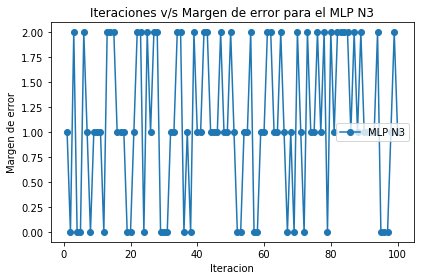

In [16]:
plt.plot(range(1,100 + 1), error_p3[:100], marker= "o", label = "MLP N3")
plt.title("Iteraciones v/s Margen de error para el MLP N3")
plt.xlabel("Iteracion")
plt.ylabel("Margen de error")
plt.legend(loc = "center right")
plt.tight_layout()
plt.show()

#### 12. Presentar una matriz de confusión del mejor modelo.

In [17]:
results_cM = confusion_matrix(y_test, y_pred3)
print(results_cM)

[[21  0  0]
 [18  0  0]
 [15  0  0]]


#### 13. Analizar y concluir sobre los resultados obtenidos en las actividades.

<p style='text-align: justify;'>
En lo que respecta a la actividad del Perceptrón Multicapa aplicado a las compuertas lógicas, esta no resultó completamente exitosa, puesto que al poner a prueba el perceptrón con una entrada XOR, este no logró diferenciar correctamente cada uno de los resultados propios de la compuerta lógica, hecho que podría darse como consecuencia de que en muchos de los casos de entrenamiento al minimizar la funcion del error, esta cae en muchos minimos locales. De todas formas, esto podría corregirse aplicando mejoras que aseguren el correcto funcionamiento del Perceptrón Multicapa.
    
Continuando con la segunda actividad, esta no resultó exitosa dado que independientemente de la configuración establecida para los tres perceptrones multicapa, ya sea variando su cantidad neuronas, las funciones de activación o el número de iteraciones, los resultados que se obtuvieron aplicando el conjunto de prueba al mismo perceptron no podían diferenciarse entre uno u otro. Este error podría estar condicionado por 2 principales factores. El primero de ellos se acota a la normalización de las variables, dado que tras este procesamiento de los datos, los mismo se agruparon entre el intervalo $[0,1]$ que podrían haber condicionado que el perceptrón no fuera capaz de diferenciar entre múltiples clases. El segundo factor se enfoca en la cantidad de capas, las que podrían resultar insuficientes para el problema que se trata en esta actividad.

De todas formas, el grupo queda satisfecho con los desarrollado en la primera parte, en especial por haber implementado de forma esperada un Perceptron Multicapa, como el elaborado en esta experiencia.
</p>